## Example classification task

This is a (work-in-progress) example of assessing synthetic data by comparing the performance of classifiers.

For a given method, two classifiers are trained: one each on the original and synthetic data.  These are both  tested using a hold-out set from the *original* dataset.  Similar performance is the desired outcome.

This can be repeated for other classification methods and tasks.

An alternative assessment is to compare the ranked performance of various methods (ignoring their absolute performance).

### Imports and setup

The output from the `2011-census-test-*` examples must be present in the usual location (`../synth-output/`). 

In [1]:
from collections import namedtuple
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.metrics import precision_score, recall_score, roc_auc_score, classification_report

### Task

Predict an individual's marital status from their other demographics.

Simplification: Predict whether an individual is single.

In [2]:
features = ["Sex", 
            "Age",
            "Country of Birth",
            "Health",
            "Ethnic Group",
            "Religion",
            "Approximated Social Grade",
            "Industry"]

### Load data

In [3]:
orig = pd.read_csv("../../datasets/2011-census-microdata/2011-census-microdata.csv")

In [4]:
# synthetic datasets ('rlsd' = released)
rlsd = {}
rlsd["synthpop 3"] = pd.read_csv("../../synth-output/2011-census-test-3-synthpop/synthetic_data_1.csv")
rlsd["synthpop 5"] = pd.read_csv("../../synth-output/2011-census-test-5-synthpop-cart/synthetic_data_1.csv")
rlsd["synthpop 10"] = pd.read_csv("../../synth-output/2011-census-test-10-synthpop-cart-proper/synthetic_data_1.csv")

In [5]:
orig

,Person ID,Region,Residence Type,Family Composition,Population Base,Sex,Age,Marital Status,Student,Country of Birth,Health,Ethnic Group,Religion,Economic Activity,Occupation,Industry,Hours worked per week,Approximated Social Grade
0,7394816,E12000001,H,2,1,2,6,2,2,1,2,1,2,5,8,2,-9,4
1,7394745,E12000001,H,5,1,1,4,1,2,1,1,1,2,1,8,6,4,3
2,7395066,E12000001,H,3,1,2,4,1,2,1,1,1,1,1,6,11,3,4
3,7395329,E12000001,H,3,1,2,2,1,2,1,2,1,2,1,7,7,3,2
4,7394712,E12000001,H,3,1,1,5,4,2,1,1,1,2,1,1,4,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569736,7946020,W92000004,H,1,1,1,5,1,2,1,4,1,9,1,8,8,3,3
569737,7944310,W92000004,H,3,1,1,3,1,2,1,2,1,1,1,7,4,3,4
569738,7945374,W92000004,H,3,1,1,1,1,1,1,1,1,2,-9,-9,-9,-9,-9
569739,7944768,W92000004,H,1,1,2,8,5,2,1,3,1,9,5,9,2,-9,4


### Basic quality checks

In [6]:
# features to visualize
features_subset = ["Age", "Marital Status", "Religion", "Occupation"]

n_plot_sample = 200000

# Kludge: Some visualizations are more straightforward with continuous data, so convert the factors to float

def recode(df):
    return df.applymap(
        lambda x: float(x) - 1 if int(x) != -9 else np.NAN
    )



def format_axis_ticks(grid):
    for ax in grid.axes.flat:
        if ax is not None:
            xticks = ax.get_xticks()
            xticks_new = [str(int(t + 1)) for t in xticks]

            yticks = ax.get_yticks()
            yticks_new = [str(int(t + 1)) for t in yticks]
            
            ax.set_xticklabels(xticks_new)
            ax.set_yticklabels(yticks_new)

    return grid

def jitter(x):
    return x + 0.3 * np.random.randn()

/var/folders/4t/76rq38xx7pn94vfcd3n5l2m0l8wv2w/T/ipykernel_10396/2062598768.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticks_new)


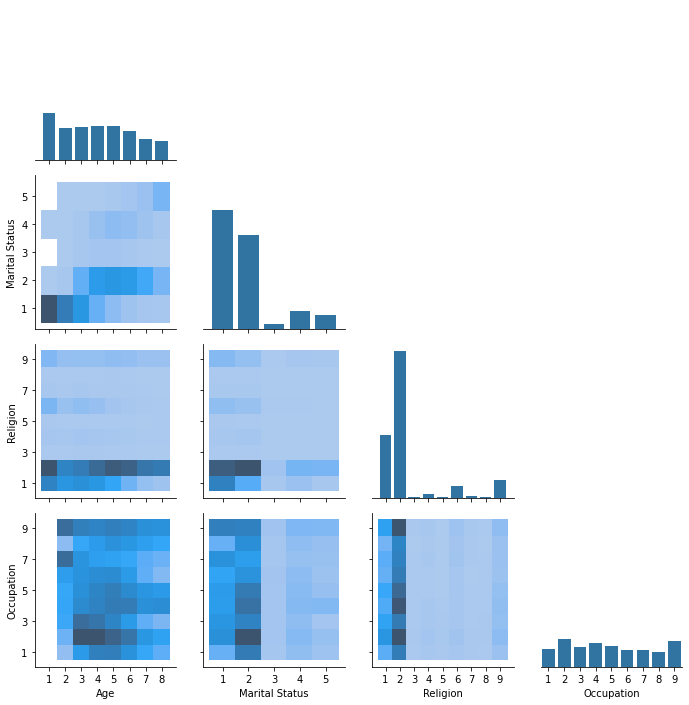

In [7]:
orig_recoded = recode(orig[features_subset])
orig_recoded['dataset'] = 'orig'

format_axis_ticks(
    sns.PairGrid(
        orig_recoded.sample(n_plot_sample),
        vars=features_subset, 
        hue='dataset',
        corner=True
    )
    .map_diag(sns.countplot)
    .map_lower(sns.histplot, discrete=True)
)

/var/folders/4t/76rq38xx7pn94vfcd3n5l2m0l8wv2w/T/ipykernel_10396/2062598768.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticks_new)


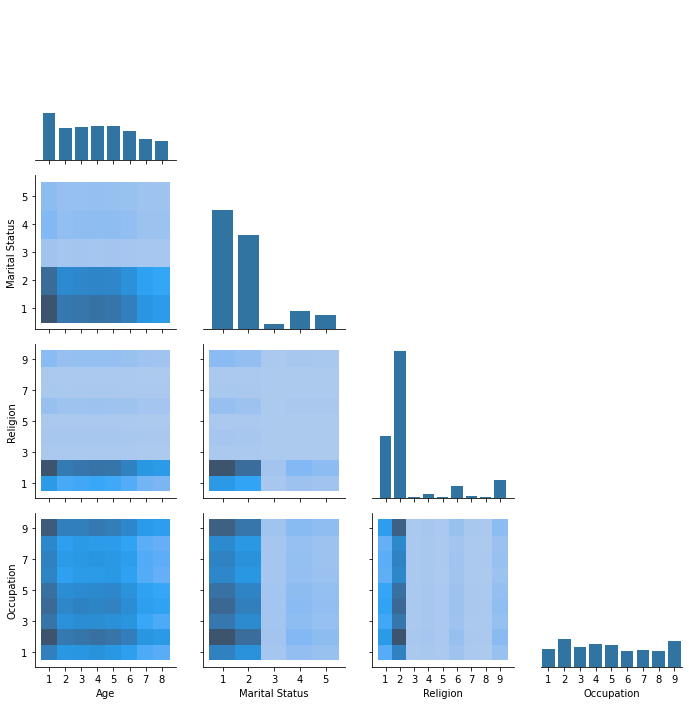

In [8]:
rlsd3_recoded = recode(rlsd["synthpop 3"][features_subset])
rlsd3_recoded["dataset"] = "synthpop 3"

format_axis_ticks(
    sns.PairGrid(
        rlsd3_recoded.sample(n_plot_sample),
        vars=features_subset,
        hue="dataset",
        corner=True,
    )
    .map_diag(sns.countplot)
    .map_lower(sns.histplot, discrete=True)
)

/var/folders/4t/76rq38xx7pn94vfcd3n5l2m0l8wv2w/T/ipykernel_10396/2062598768.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticks_new)


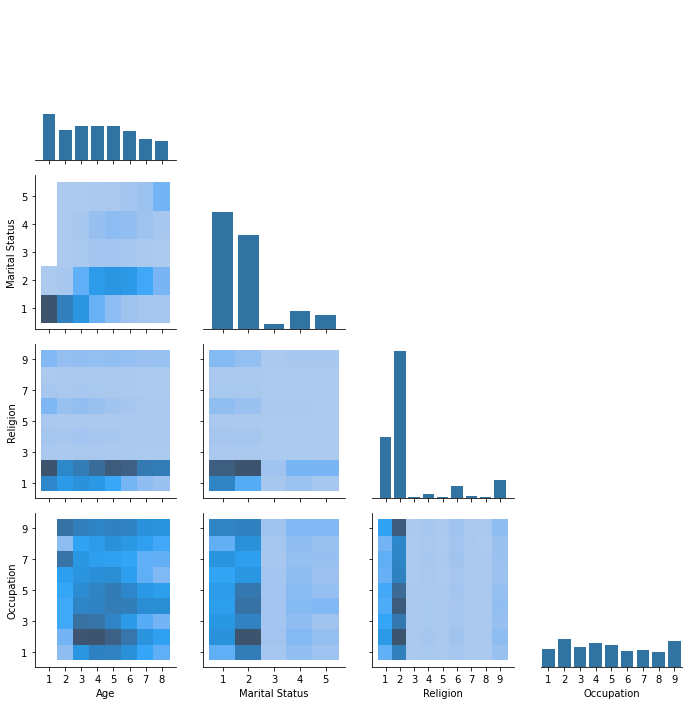

In [9]:
rlsd10_recoded = recode(rlsd["synthpop 10"][features_subset])
rlsd10_recoded["dataset"] = "synthpop 10"

format_axis_ticks(
    sns.PairGrid(
        rlsd10_recoded.sample(n_plot_sample),
        vars=features_subset,
        hue="dataset",
        corner=True,
    )
    .map_diag(sns.countplot)
    .map_lower(sns.histplot, discrete=True)
)

/var/folders/4t/76rq38xx7pn94vfcd3n5l2m0l8wv2w/T/ipykernel_10396/2062598768.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticks_new)
/var/folders/4t/76rq38xx7pn94vfcd3n5l2m0l8wv2w/T/ipykernel_10396/2062598768.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticks_new)


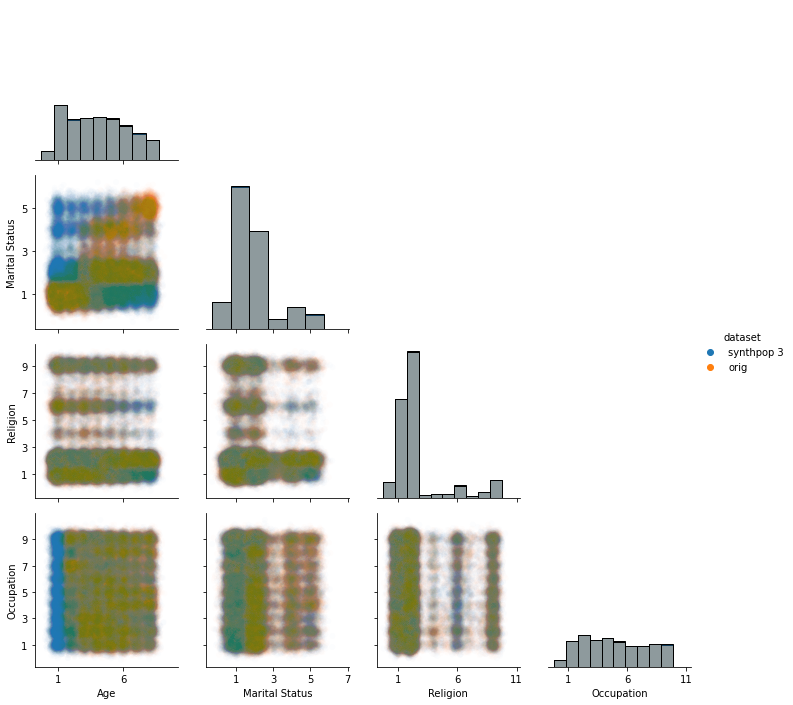

In [10]:
combined = orig_recoded.append(rlsd3_recoded, ignore_index=True)

# apply jitter (for scatter plot)
combined[features_subset] = combined[features_subset].applymap(jitter)

format_axis_ticks(
    sns.PairGrid(
        combined.sample(n_plot_sample),
        vars=features_subset,
        hue='dataset',
        corner=True
    )
    .map_diag(sns.histplot, binwidth=1.0)
    .map_lower(sns.scatterplot, alpha=0.01, sizes=(10,10))
    .add_legend()
)

/var/folders/4t/76rq38xx7pn94vfcd3n5l2m0l8wv2w/T/ipykernel_10396/2062598768.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticks_new)
/var/folders/4t/76rq38xx7pn94vfcd3n5l2m0l8wv2w/T/ipykernel_10396/2062598768.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticks_new)


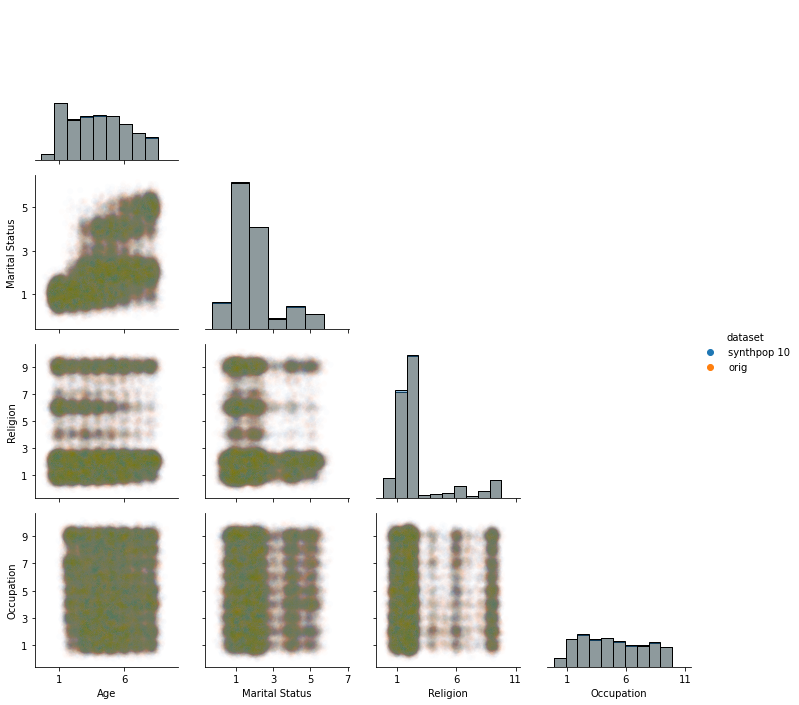

In [11]:
rlsd10_recoded = recode(rlsd["synthpop 10"][features_subset])
rlsd10_recoded["dataset"] = "synthpop 10"

combined2 = orig_recoded.append(rlsd10_recoded, ignore_index=True)
combined2[features_subset] = combined2[features_subset].applymap(jitter)

format_axis_ticks(
    sns.PairGrid(
        combined2.sample(n_plot_sample),
        vars=features_subset,
        hue='dataset',
        corner=True,
    )
    .map_diag(sns.histplot, binwidth=1.0)
    .map_lower(sns.scatterplot, alpha=0.01, sizes=(10.0, 10.0))
    .add_legend()
)

### Train and compare classifiers

From the [data dictionary](https://www.ons.gov.uk/census/2011census/2011censusdata/censusmicrodata/microdatateachingfile/variablelist)

Marital Status:

 | Category | Definition  |
 |:-- |:-- |
 |1 | Single (never married or never registered a same-sex civil partnership) |
 |2 | Married or in a registered same-sex civil partnership  |
 |3 | Separated but still legally married or separated but still legally in a same-sex civil partnership  |
 |4 | Divorced or formerly in a same-sex civil partnership which is now legally dissolved  |
 |5 | Widowed or surviving partner from a same-sex civil partnership |

In [12]:
def is_single(df):
    return df['Marital Status'].mask(df['Marital Status'] > 1, 0)

In [13]:
y_orig = is_single(orig)
y_orig.value_counts()

0    298742
1    270999
Name: Marital Status, dtype: int64

In [14]:
fit_result = namedtuple('fit_result', 'classifier, X_train, X_test, y_train, y_test')
eval_result = namedtuple('eval_result', 'classifier, report')

In [15]:
class ClassifierCmp:
    def __init__(self, orig, model):
        self.orig = orig
        self.model = model
        
        self.clf_orig, _, self.X_test_orig, _, self.y_test_orig = self._fit(
            orig[features], is_single(orig)
        )
        
    def _fit(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
        
        return fit_result(classifier=self.model.fit(X_train, y_train),
                          X_train=X_train,
                          X_test=X_test,
                          y_train=y_train,
                          y_test=y_test)
    
    def evaluate_orig(self):
        report = classification_report(
            self.y_test_orig,
            self.clf_orig.predict(self.X_test_orig)
        )
        
        return eval_result(classifier=self.clf_orig, report=report)
    
    def evaluate_rlsd(self, rlsd):
        clf_rlsd = self._fit(rlsd[features], is_single(rlsd)).classifier
        
        report = classification_report(
            self.y_test_orig, 
            clf_rlsd.predict(self.X_test_orig)
        )
        
        return eval_result(classifier=clf_rlsd, report=report)

### Logistic regression

In [16]:
cmp_lr = ClassifierCmp(orig, LogisticRegression(solver="sag"))

eval_results_lr = { k: cmp_lr.evaluate_rlsd(dataset) 
                    for k, dataset in rlsd.items() }

/Users/ostrickson/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
print("orig: ")
print(cmp_lr.evaluate_orig().report)

for dataset, result in eval_results_lr.items():
    print("-----\n")
    print(f"{dataset}:")
    print(f"{result.report}\n")

orig: 
              precision    recall  f1-score   support

           0       0.85      0.89      0.87     74829
           1       0.87      0.83      0.85     67607

    accuracy                           0.86    142436
   macro avg       0.86      0.86      0.86    142436
weighted avg       0.86      0.86      0.86    142436

-----

synthpop 3:
              precision    recall  f1-score   support

           0       0.53      1.00      0.69     74829
           1       0.00      0.00      0.00     67607

    accuracy                           0.53    142436
   macro avg       0.26      0.50      0.34    142436
weighted avg       0.28      0.53      0.36    142436


-----

synthpop 5:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87     74829
           1       0.87      0.83      0.85     67607

    accuracy                           0.86    142436
   macro avg       0.86      0.86      0.86    142436
weighted avg       0.86     

### Random Forest

In [18]:
cmp = ClassifierCmp(orig, RandomForestClassifier())

eval_results_rf = { k: cmp.evaluate_rlsd(dataset) 
                    for k, dataset in rlsd.items() }

In [19]:
print("orig:")
print(cmp.evaluate_orig().report)

for dataset, result in eval_results_rf.items():
    print("-----\n")
    print(f"{dataset}:")
    print(f"{result.report}\n")

orig:
              precision    recall  f1-score   support

           0       0.85      0.91      0.87     74566
           1       0.89      0.82      0.85     67870

    accuracy                           0.86    142436
   macro avg       0.87      0.86      0.86    142436
weighted avg       0.87      0.86      0.86    142436

-----

synthpop 3:
              precision    recall  f1-score   support

           0       0.50      0.59      0.54     74566
           1       0.43      0.34      0.38     67870

    accuracy                           0.47    142436
   macro avg       0.46      0.47      0.46    142436
weighted avg       0.47      0.47      0.46    142436


-----

synthpop 5:
              precision    recall  f1-score   support

           0       0.85      0.91      0.88     74566
           1       0.89      0.82      0.85     67870

    accuracy                           0.86    142436
   macro avg       0.87      0.86      0.86    142436
weighted avg       0.87      